# 顔の表情を認識させるコードを書いてみた

このコードは顔の表情を認識させるアプリを書く時の参考のために使用している。とりあえず、手頃なデータセットを使用してみた。

まずは使用するモジュールを紹介する。今回はpy-featを使った。

In [2]:
import feat
import cv2
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import re
import os

次に検証に使用するデータセットについても触れる。今回使用したのは https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition/ からダウンロードしてきた画像データである。
画像データの一つを紹介すると、

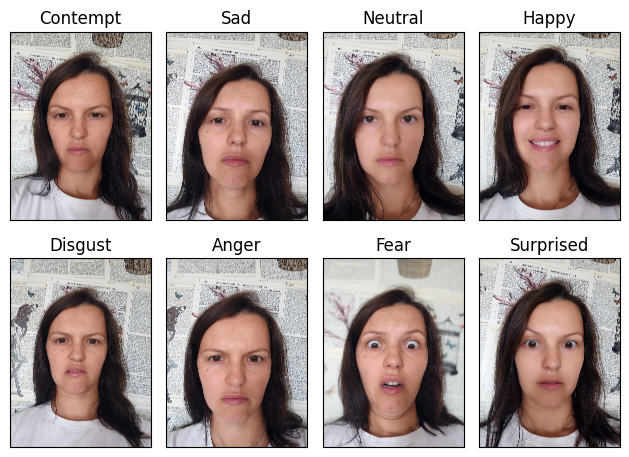

In [3]:
dataset_path = './dataset/images/0'
dataset_list = list(pathlib.Path(dataset_path).glob('**/*.jpg'))
row_num = 2
column_num = 4
fig, axes = plt.subplots(row_num, column_num, tight_layout = True)

for i in range(len(dataset_list)):
    
    img_file_name = str(dataset_list[i])
    img = cv2.imread(img_file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row = int(i)//int(column_num)
    column = int(i)%int(column_num)
    
    axes[row, column].xaxis.set_major_locator(plt.NullLocator())
    axes[row, column].yaxis.set_major_locator(plt.NullLocator())
    axes[row, column].imshow(img, cmap="bone")
    axes[row, column].set_title(img_file_name.removeprefix('dataset/images/0/').removesuffix('.jpg'))

plt.show()

このデータセットを利用する。py-featを用いてとりあえずAngerの画像を利用してどのような動作をするか確認。

In [4]:
from feat import Detector
# rf: https://py-feat.org/content/intro.html#available-models
face_model = "retinaface"
landmark_model = "mobilefacenet"
au_model = "xgb"
emotion_model = "resmasknet"
facepose_model="img2pose"

detector = Detector(
    face_model=face_model,
    landmark_model=landmark_model,
    au_model=au_model,
    emotion_model=emotion_model
    #facepose_model=facepose_model
)

100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


[<Figure size 1500x700 with 3 Axes>]

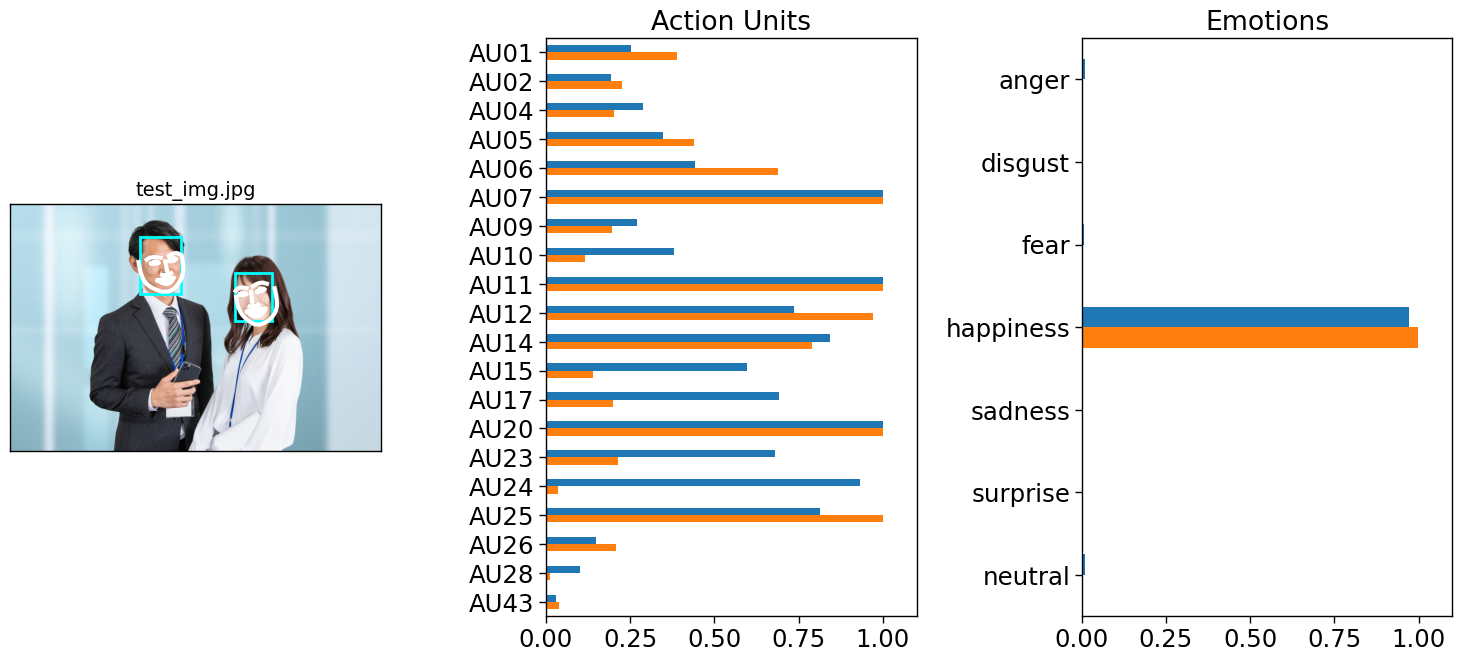

In [9]:
#img_path = 'dataset/images/0/Neutral.jpg'
img_path = 'dataset/test_img.jpg'
#fig, axes = plt.subplots()
#img = cv2.imread(img_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_prediction = detector.detect_image(img_path)
# Show results
image_prediction
image_prediction.plot_detections()

上記の結果から分かるようにtest_img.jpgでしっかりhappinessと分類されている。